In [628]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.backend import square, mean

look_back = 4 * 24 * 4
num_epochs = 7
# seq_len = 4 * 2
batch_size=256
loss="mse"
ewm=8
units=256

shift_steps=4 * 2

warmup_steps=0

In [629]:
# def getDataset():
#     url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
#     df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
#     df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
#     df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
#     df.set_axis(df['date'], inplace=True)
#     df.drop(columns=["date"], inplace=True)
#     df["Close"]= df["close"] # compatibility
#     df.drop(columns=['close'], inplace=True)
#     return df

In [630]:
def getDataset():
    url = "./datasets/eurusd-m15-2018/EURUSD.csv"
    df = pd.read_csv(url)
    df.drop("Volume", 1, inplace=True)
    df["Date"] = df["Date"].astype(str) + " " + df["Timestamp"]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index("Date", inplace=True)
    # df.drop("Date", 1, inplace=True)
    df.drop("Timestamp", 1, inplace=True)
    df.drop("Open", 1, inplace=True)
    df.drop("High", 1, inplace=True)
    df.drop("Low", 1, inplace=True)

    return df

In [631]:
df = getDataset()
df.head()

,Close
Date,
2015-01-25 22:00:00,1.11380
2015-01-25 22:15:00,1.11422
2015-01-25 22:30:00,1.11482
2015-01-25 22:45:00,1.11430
2015-01-25 23:00:00,1.11425


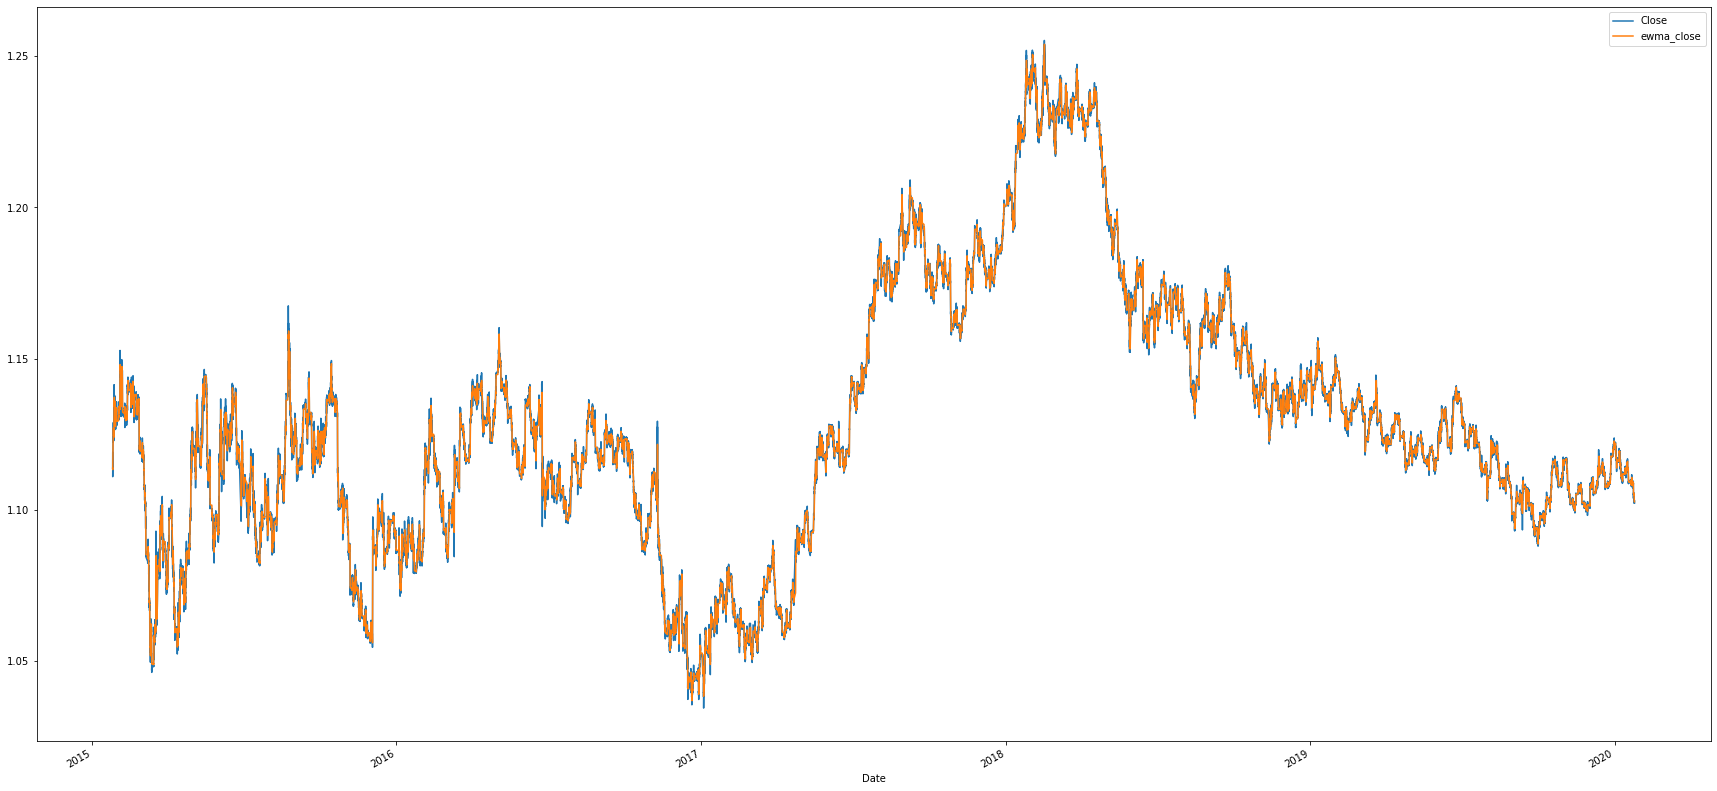

In [632]:
df["ewma_close"]=df["Close"].ewm(ewm).mean()
df.plot(figsize=(30,15))

In [633]:
df["targets"]=df["ewma_close"].shift(-shift_steps) # yeah, that minus there is realllyyyy important
df.drop(columns=["Close"], inplace=True)
print(df_targets)

Date
2015-01-25 22:00:00    1.113800
2015-01-25 22:15:00    1.114022
2015-01-25 22:30:00    1.114320
2015-01-25 22:45:00    1.114314
2015-01-25 23:00:00    1.114298
                         ...   
2020-01-24 20:45:00    1.102833
2020-01-24 21:00:00    1.102836
2020-01-24 21:15:00    1.102826
2020-01-24 21:30:00    1.102789
2020-01-24 21:45:00    1.102728
Name: ewma_close, Length: 124644, dtype: float64


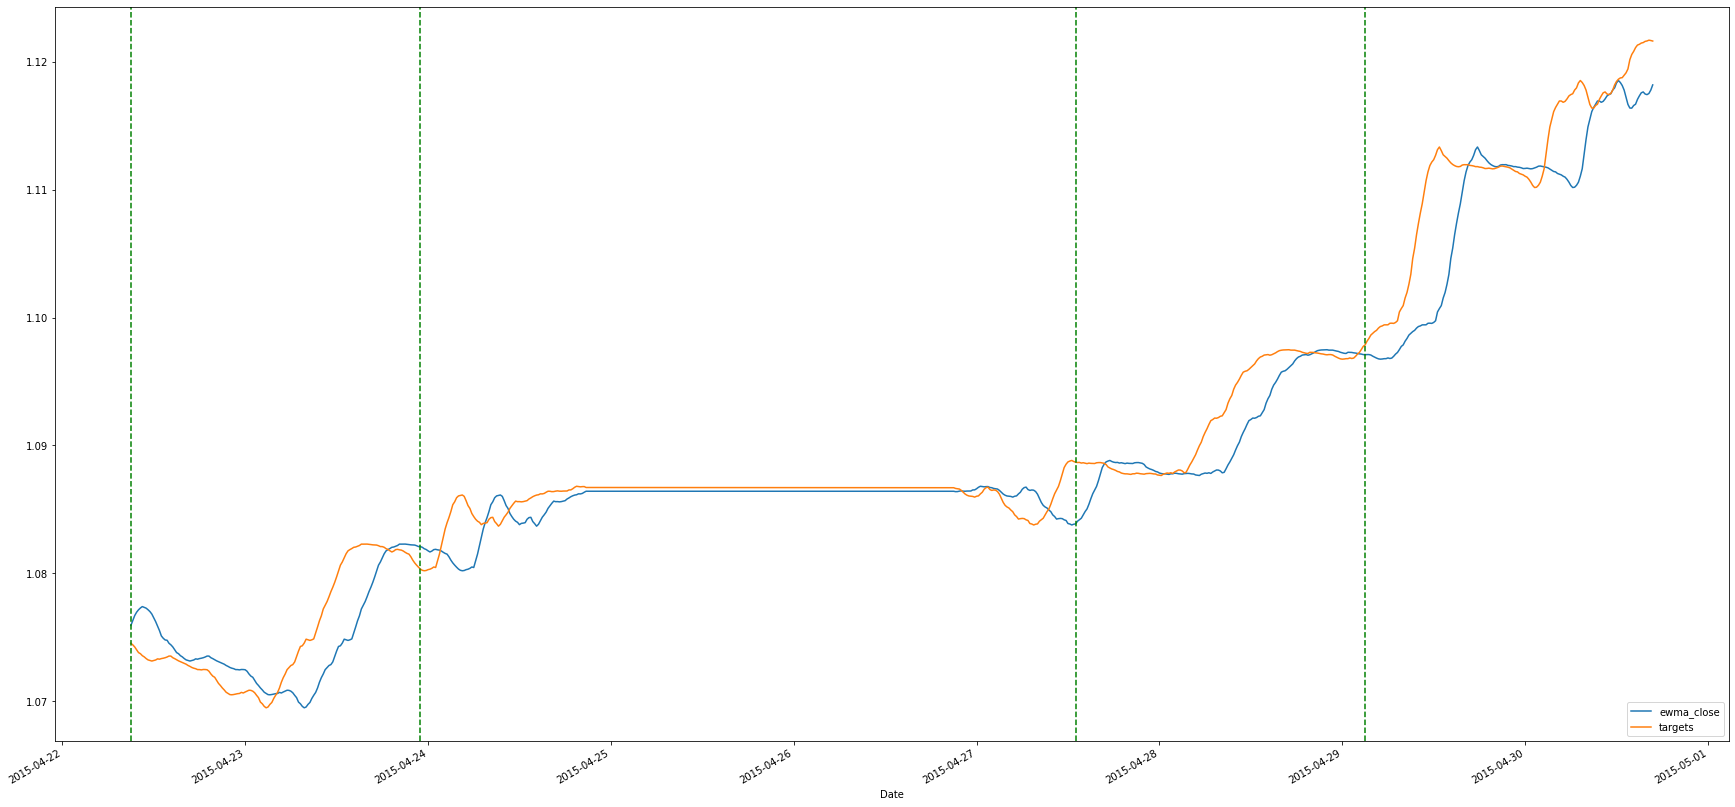

In [634]:
offset=6000
period_num=4
ax=df[offset:offset+period_num*look_back].plot(figsize=(30,15))
for i in range(period_num):
    ax.axvline(df.index[offset+i*look_back], color="green", linestyle="--")

In [635]:
df_targets=df["ewma_close"]
x_data=df["targets"].values[0:-shift_steps]
print(type(x_data))
print("shape:", x_data.shape)

<class 'numpy.ndarray'>
shape: (124624,)


In [636]:
y_data=df_targets.values[0:-shift_steps]
print(type(y_data))
print("shape:", y_data.shape)

<class 'numpy.ndarray'>
shape: (124624,)


In [637]:
train_split = 0.9

In [638]:
num_data = len(x_data)

In [639]:
num_train = int(train_split * num_data)
num_train

112161

In [640]:
num_test = num_data - num_train
num_test

12463

In [641]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

124624

In [642]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

124624

In [643]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 1.0369760662206036
Max: 1.2539174610373232


In [644]:
x_scaler = MinMaxScaler()
x_train_reshaped = x_train.reshape(-1,1)
x_train_scaled = x_scaler.fit_transform(x_train_reshaped)

In [645]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [646]:
x_test_reshaped=x_test.reshape(-1,1)
x_test_scaled = x_scaler.transform(x_test_reshaped)

In [647]:
y_scaler = MinMaxScaler()
y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_train_scaled = y_scaler.fit_transform(y_train_reshaped)
y_test_scaled = y_scaler.transform(y_test_reshaped)

In [648]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(112161, 1)
(112161, 1)


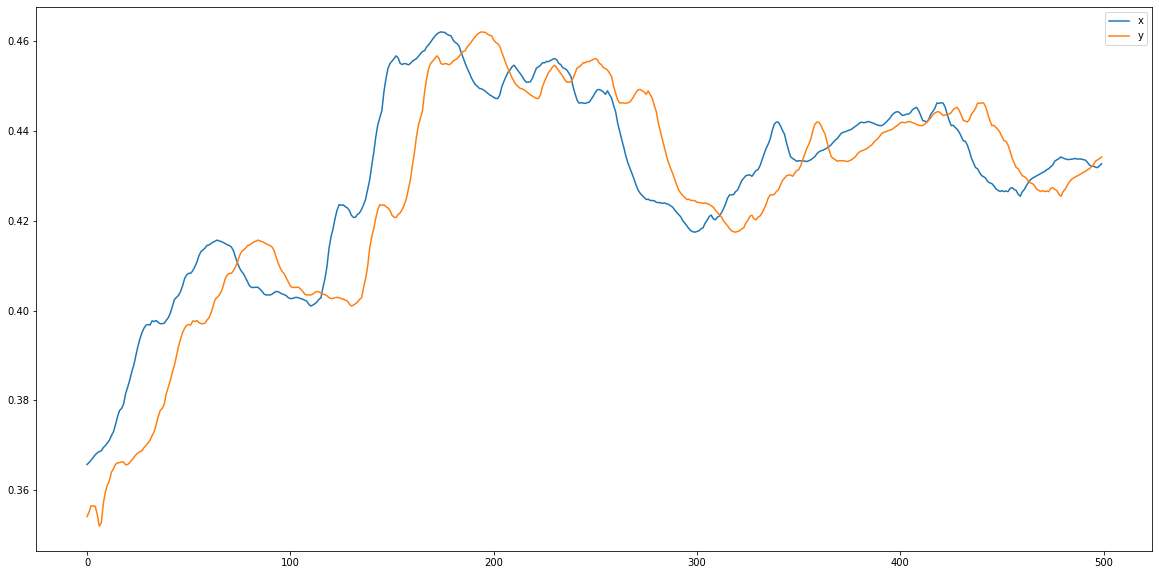

In [649]:
def printXYData(x,y, start=0, end=200):
    x_re=x.reshape(1,-1)[0]
    y_re=y.reshape(1,-1)[0]
    pd.DataFrame(data={"x":x_re[start:end], "y":y_re[start:end]}).plot(figsize=(20,10))


printXYData(x_train_scaled, y_train_scaled, 0, 500)

In [650]:
def createTrainData(inp, output):
    x=[]
    y=[]
    for i in range(look_back, inp.shape[0]):
        x.append(inp[i-look_back:i])
        y.append(output[i-look_back:i])
    return np.array(x), np.array(y)

x_tr, y_tr = createTrainData(x_train_scaled, y_train_scaled)
x_te, y_te = createTrainData(x_test_scaled, y_test_scaled)




In [651]:
validation_data = (x_te, y_te)

In [652]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
# model.add(Dense(num_y_signals, activation='sigmoid'))


init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(1, activation='linear', kernel_initializer=init))

In [653]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    # print(y_pred[0][0][0])
    # print(y_true.numpy())
    # print(y_pred.numpy())

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]
    # print(y_true, y_pred)
    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [654]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [655]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, None, 512)         791040    
_________________________________________________________________
dense_12 (Dense)             (None, None, 1)           513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [656]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)                           
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.5,
                                       min_lr=1e-9,
                                       patience=3,
                                       verbose=1) 
callbacks = [callback_early_stopping,
             callback_reduce_lr]                                                                   

In [657]:
%%time
history=model.fit(x_te, y_te,
          epochs=EPOCHS,
          batch_size=64, shuffle=True,
        #   steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/9
193/193 [==============================] - 106s 547ms/step - loss: 0.0092 - val_loss: 3.8957e-04 - lr: 0.0010
Epoch 2/9
193/193 [==============================] - 100s 521ms/step - loss: 8.3011e-04 - val_loss: 3.5747e-04 - lr: 0.0010
Epoch 3/9
193/193 [==============================] - 96s 495ms/step - loss: 5.4912e-04 - val_loss: 1.8194e-04 - lr: 0.0010
Epoch 4/9
193/193 [==============================] - 105s 542ms/step - loss: 4.0753e-04 - val_loss: 1.4516e-04 - lr: 0.0010
Epoch 5/9
193/193 [==============================] - 99s 513ms/step - loss: 3.1162e-04 - val_loss: 8.1077e-04 - lr: 0.0010
Epoch 6/9
193/193 [==============================] - 94s 489ms/step - loss: 2.6246e-04 - val_loss: 5.1636e-05 - lr: 0.0010
Epoch 7/9
193/193 [==============================] - 94s 486ms/step - loss: 2.1801e-04 - val_loss: 2.4081e-04 - lr: 0.0010
Epoch 8/9
193/193 [==============================] - 100s 517ms/step - loss: 1.8537e-04 - val_loss: 1.5424e-04 - lr: 0.0010
Epoch 9/9
193/19

In [658]:
def plotHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['loss'], label='loss (training data)')
    ax.plot(history.history['val_loss'], label='loss (validation data)')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    ax.legend(loc="upper left")
    plt.title(f"loss = {loss}")
    plt.show()

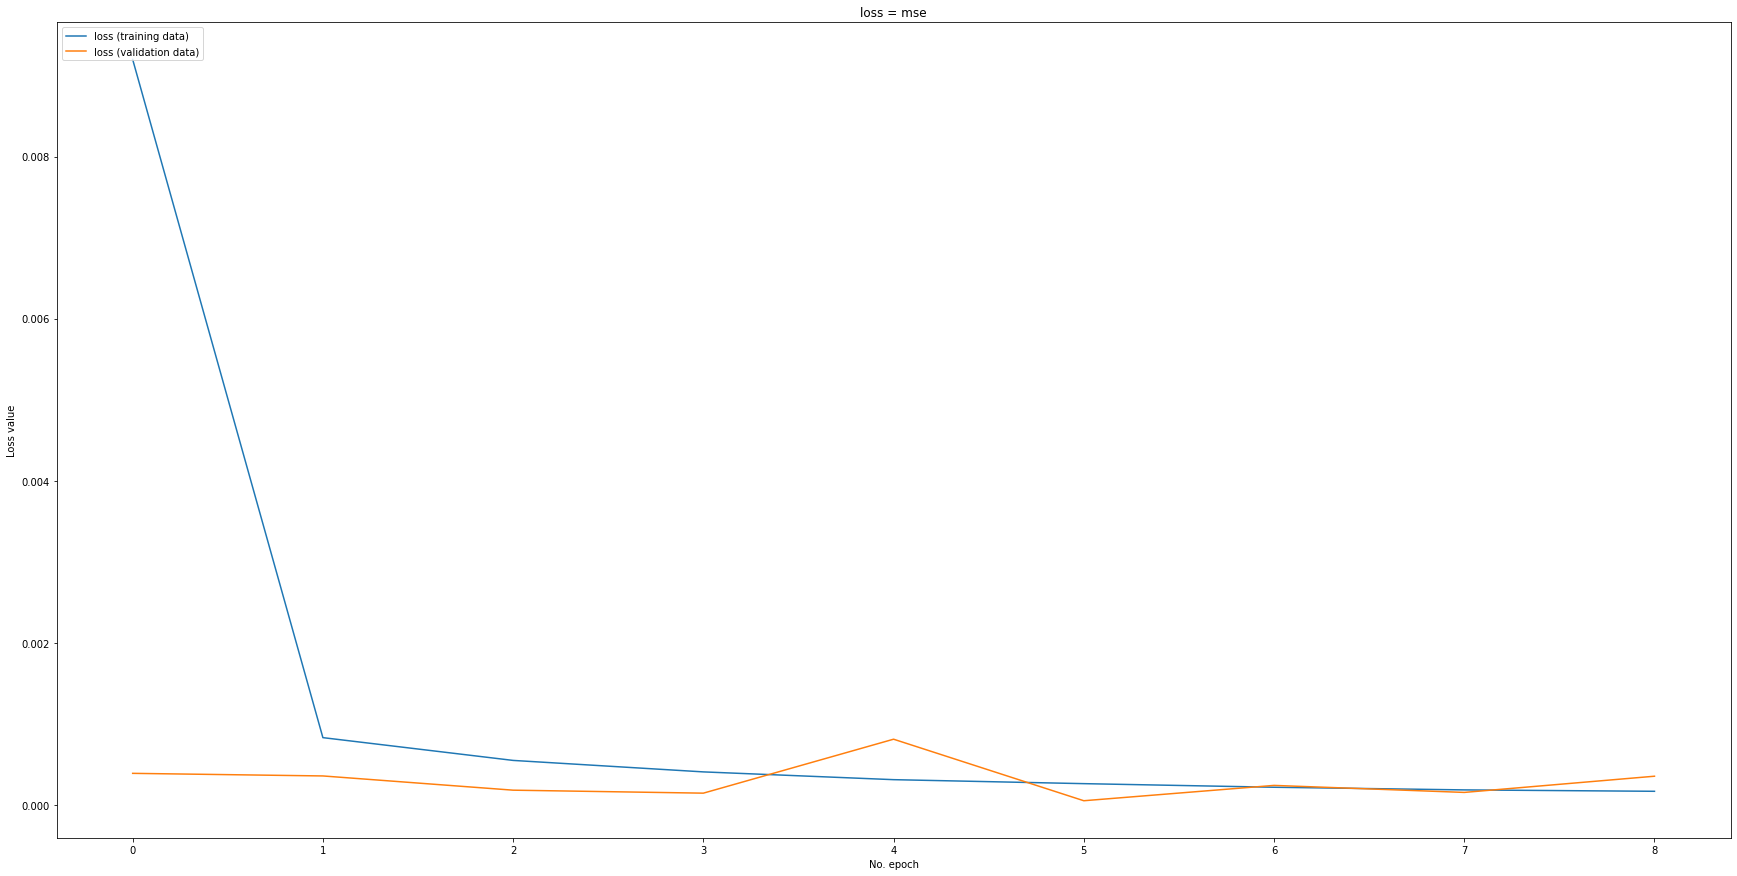

In [659]:
plotHistory(history)

In [660]:
result = model.evaluate(x=x_te, y=y_te)

385/385 [==============================] - 34s 89ms/step - loss: 3.5414e-04


In [661]:
print("loss (test-set):", result)

loss (test-set): 0.0003541356709320098


In [662]:
def plot_comparison(start_idx, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_tr
        y_true = y_tr
    else:
        # Use test-data.
        x = x_te
        y_true = y_te
    
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx]
    y_true = y_true[start_idx]
    
    # x_orig=x_scaler.inverse_transform(x)

    # Input-signals for the model.
    # x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(np.array([x]))[0]
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    x_rescaled=x_scaler.inverse_transform(x).reshape(1,-1)[0]
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled.reshape(1,-1)[0]
    
    # Get the true output-signal from the data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_true)
    signal_true = y_pred_rescaled.reshape(1,-1)[0]
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(30,15))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    plt.plot(x_rescaled, label='x')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(TARGET_VALUE)
    plt.legend()
    plt.show()

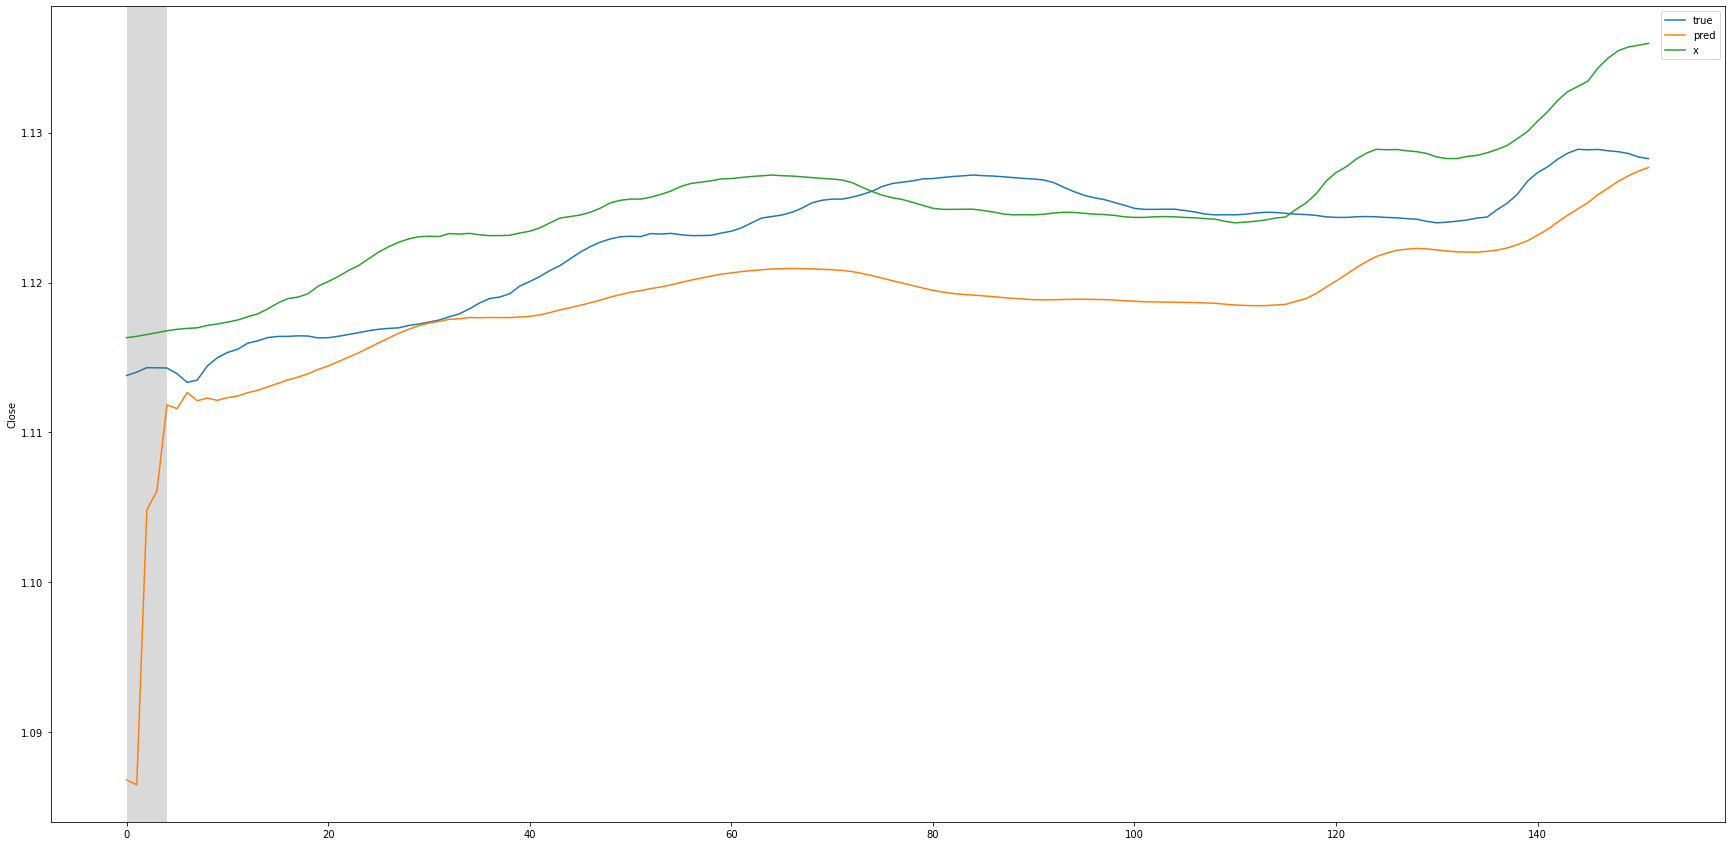

In [663]:
plot_comparison(start_idx=0, train=True)

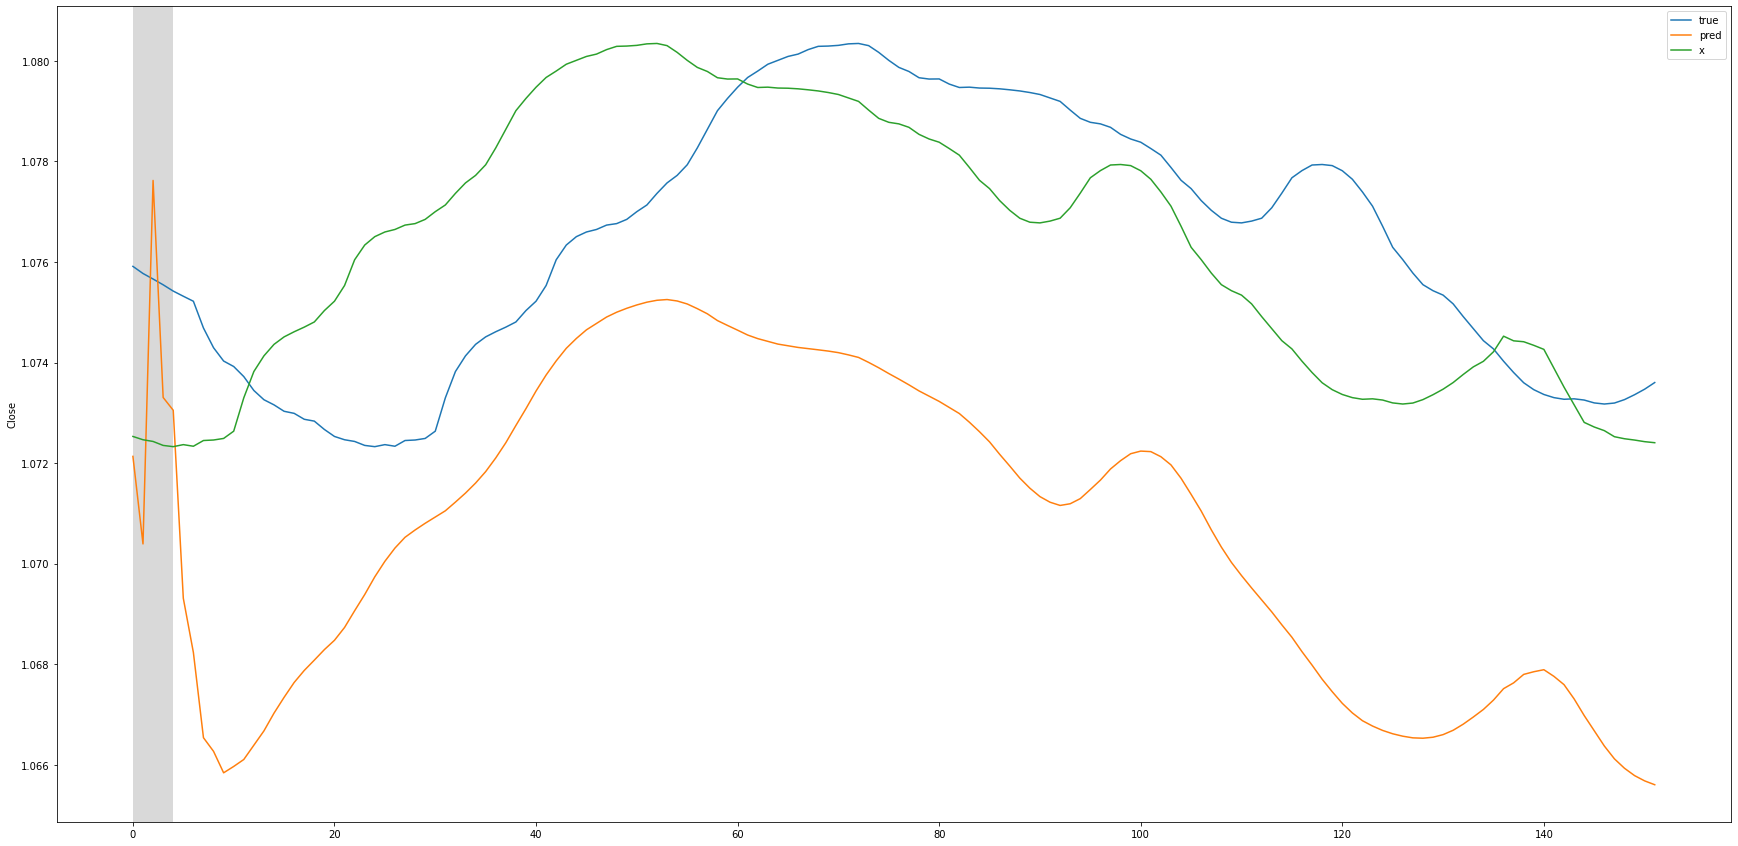

In [664]:
plot_comparison(start_idx=20000, train=True)

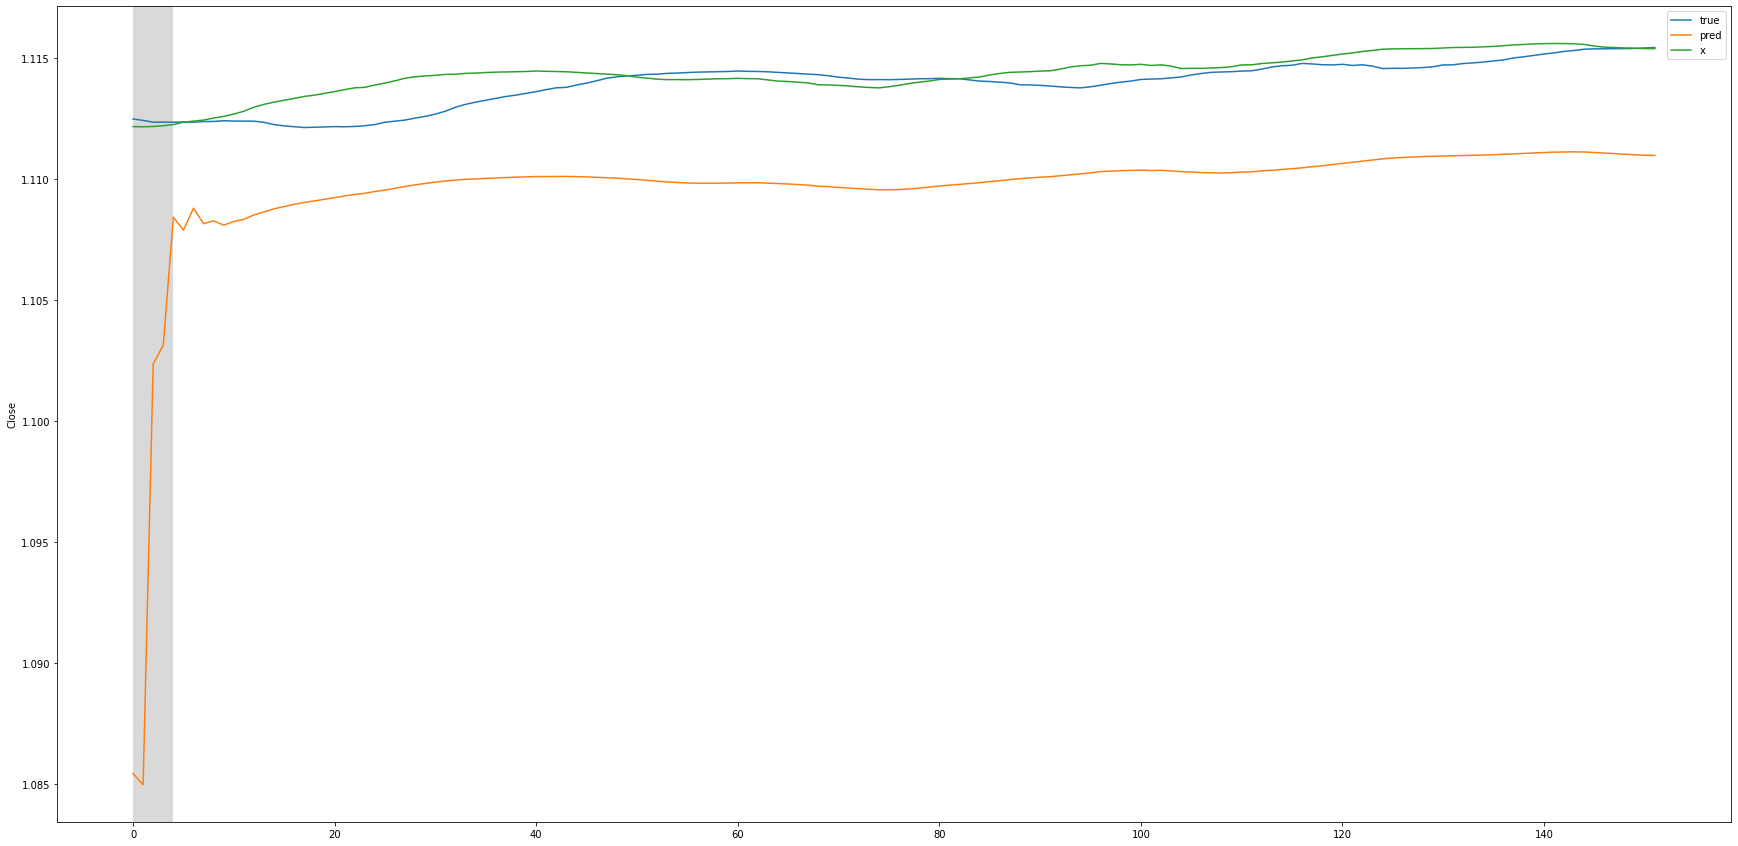

In [665]:
plot_comparison(start_idx=200, train=False)

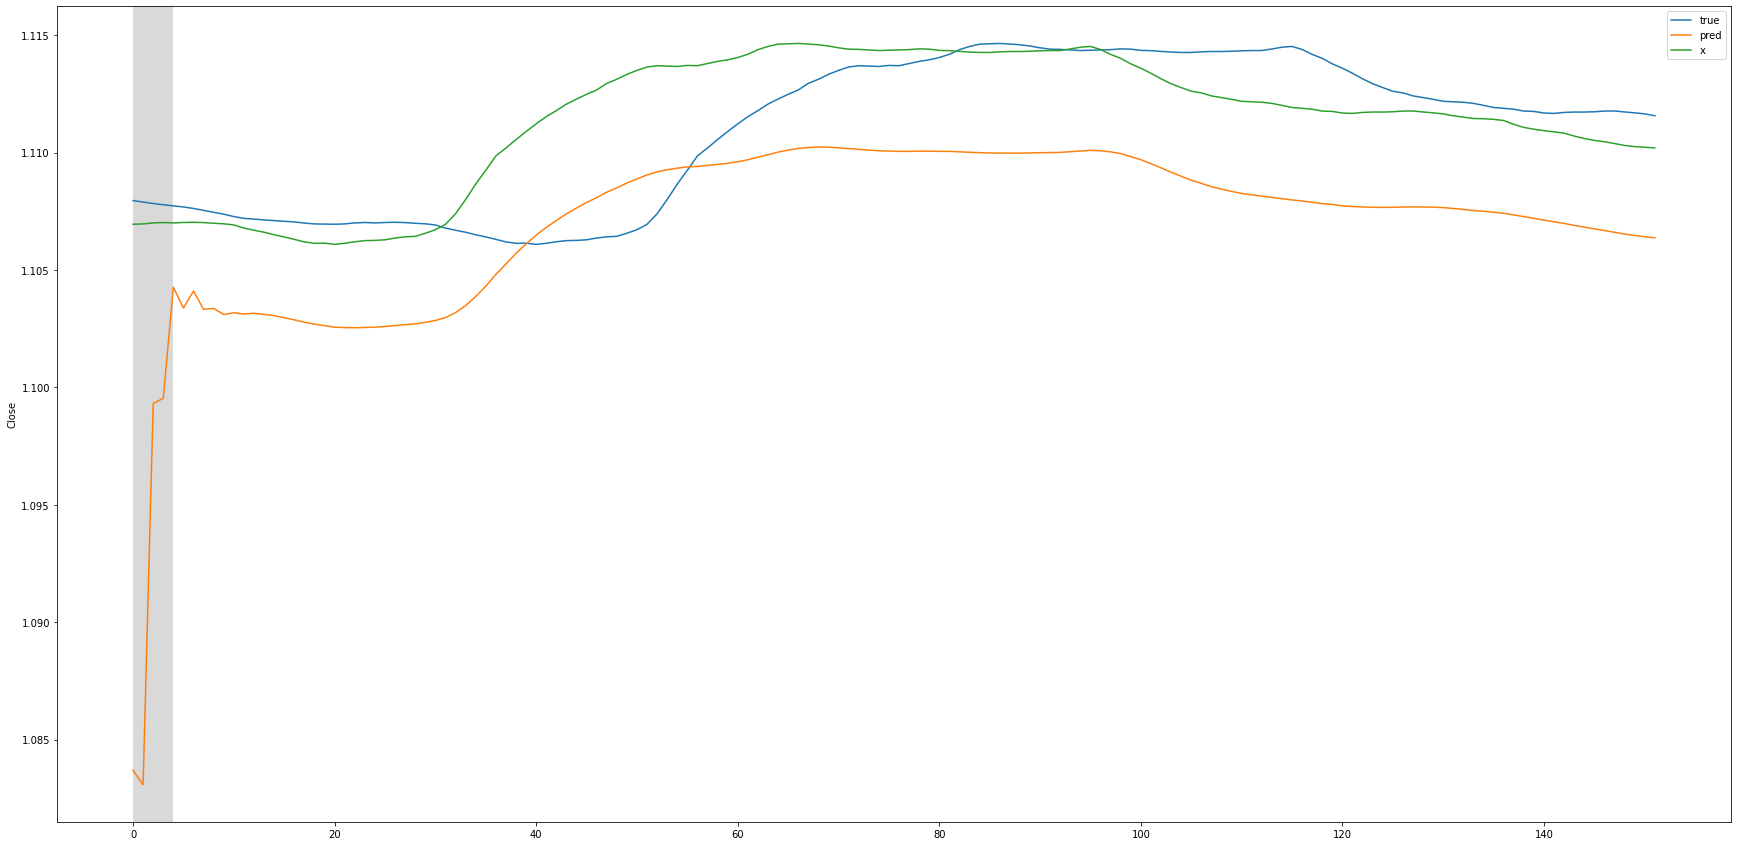

In [666]:
plot_comparison(start_idx=2000, train=False)